# **PLS  (Partial Least Square)를 이용한 Odor 분석**

---

odo : All Data

odos : Variable Select

---

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
package_version(R.version)

[1] ‘4.0.5’


In [3]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**
---

In [4]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("pls")                       # pls
# install.packages("caret")         
# install.packages("mice")    # M.I 결측치 대체
# install.packages("stringr")
# install.packages("devtools")
# install.packages("lmtest")      # Durbin-Watson test (잔차의 독립성)
# install.packages("Boruta")

library(Boruta)
library(lmtest)
library(devtools)
library(mice)
library(stringr)
library(corrplot)
library(PerformanceAnalytics)
library(pls)
library(caret)

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Loading required package: usethis

R[write to console]: 
Attaching package: ‘mice’


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: The following objects are masked from ‘package:base’:

    cbind, rbind


R[write to console]: corrplot 0.84 loaded

R[write to console]: Loading required package: xts

R[write to console]: 
Attaching package: ‘PerformanceAnalytics’


R[write to console]: The following object is masked from ‘package:graphics’:

    legend


R[write to console]: 
Attaching package: ‘pls’


R[write to console]: The following object is masked from ‘package:corrplot’:

    corrplot


R[write to console]: The following object is masked from ‘package:stats’:

    loadings


R[write to console]

**plsVarSel은  R version 4.0.5에서 지원하지 않으므로, Version을 지정해 다운해야된다.**

In [5]:
%%R
# install_version("plsVarSel", version = "0.9.6", repos = "http://cran.us.r-project.org") # VIP
library(plsVarSel)

## **1. Data Preparation** 
---

### **1) Read and Select to variable (odo)** 

In [6]:
%%R

# getwd()
od1 <- read.csv("drive/MyDrive/PLS_양돈 농가/s1.csv", fileEncoding = "euc-kr")
od2 <- read.csv("drive/MyDrive/PLS_양돈 농가/s2.csv", fileEncoding = "euc-kr")
od3 <- read.csv("drive/MyDrive/PLS_양돈 농가/s3.csv", fileEncoding = "euc-kr")
od4 <- read.csv("drive/MyDrive/PLS_양돈 농가/s4.csv", fileEncoding = "euc-kr")
head(od1)

    측정일 complex.odor Ammoina Hydorgen.sulfide Methyl.mercaptan
1 18.04.24           NA      NA               NA               NA
2 18.05.08           NA      NA               NA               NA
3 18.05.15           NA      NA               NA               NA
4 18.05.22           NA      NA               NA               NA
5 18.05.29           10      NA             0.25             0.07
6 18.06.05           14      NA             0.88             0.07
  Dimethyl.sulfide Dimethyl.disulfide Acetic.acid Propionic.acid
1               NA                 NA     1272.66          354.4
2               NA                 NA       34.23          15.96
3               NA                 NA       22.93           7.23
4               NA                 NA       30.94          11.72
5             0.07               0.02       17.53           6.67
6             0.08               0.04       12.40            4.2
  iso.Butryic.aicd Butricy.aicd iso.Valeric.acid Valeric.acid Phenol p.Cresol
1       

In [7]:
%%R

### 측정일, 농장명 변수 제거 

odo1 <- subset(od1, select = -c(측정일, 농장명))
odo2 <- subset(od2, select = -c(측정일, 농장명))
odo3 <- subset(od3, select = -c(측정일, 농장명))
odo4 <- subset(od4, select = -c(측정일, 농장명))
head(odo1)

  complex.odor Ammoina Hydorgen.sulfide Methyl.mercaptan Dimethyl.sulfide
1           NA      NA               NA               NA               NA
2           NA      NA               NA               NA               NA
3           NA      NA               NA               NA               NA
4           NA      NA               NA               NA               NA
5           10      NA             0.25             0.07             0.07
6           14      NA             0.88             0.07             0.08
  Dimethyl.disulfide Acetic.acid Propionic.acid iso.Butryic.aicd Butricy.aicd
1                 NA     1272.66          354.4             0.16        10.14
2                 NA       34.23          15.96             2.02        20.60
3                 NA       22.93           7.23             0.95         5.77
4                 NA       30.94          11.72             1.29        14.24
5               0.02       17.53           6.67             1.25         1.49
6             

### **2) 결측치 확인 및 처리**

#### **a. ND - > 0, 결측 -> M.I**

In [8]:
%%R

naf <- function(odo) {
      ### 공백을 NA 값 취급
      odo <- replace(odo, odo == "", NA)


      ### 결측치 확인
      nd <- sum(str_count(odo, "ND"))
      na <- sum(is.na(odo))

      cat("NA , NA 개수 :", (na+nd), "개 \n \n")


      if ((nd + na) == 0) {
          print("결측치 개수 : 0 개")
      }else{
          
          # "ND" 먼저 제거 (그래야 ND와 문자열 공백(NA)구분 가능)
          cat("'ND' 개수 :", nd, "개")
          odo <- replace(odo, odo == "ND", 0)
          cat("->", sum(str_count(odo, "ND")), "개 (0으로 대체) \n \n")

          # 문자열을 숫자열로 변환(공백 문자를 NA로 바꾸기 위해서)
          indx <- sapply(odo, is.character)
          odo[indx] <- lapply(odo[indx], function(x) as.numeric(as.character(x)))

          cat("결측치 개수 :", na, "개")
          imp <- mice(odo)      # M.I 사용
          odo <- complete(imp)
          cat("\n ->", sum(is.na(odo)), "개 (M.I로 대체)")
      }
      return(odo)
    }

In [9]:
%%R

odo1 <- naf(odo1)
odo2 <- naf(odo2)
odo3 <- naf(odo3)
odo4 <- naf(odo4)

NA , NA 개수 : 51 개 
 
'ND' 개수 : 8 개-> 0 개 (0으로 대체) 
 
결측치 개수 : 43 개
 iter imp variable
  1   1  complex.odor  Ammoina  Hydorgen.sulfide  Methyl.mercaptan  Dimethyl.sulfide  Dimethyl.disulfide  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   2  complex.odor  Ammoina  Hydorgen.sulfide  Methyl.mercaptan  Dimethyl.sulfide  Dimethyl.disulfide  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   3  complex.odor  Ammoina  Hydorgen.sulfide  Methyl.mercaptan  Dimethyl.sulfide  Dimethyl.disulfide  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   4  complex.odor  Ammoina  Hydorgen.sulfide  Methyl.mercaptan  Dimethyl.sulfide  Dimethyl.disulfide  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol

### **3) Data visualizations (odo)**



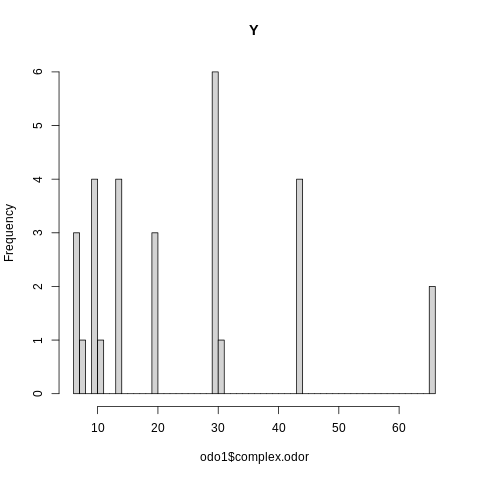

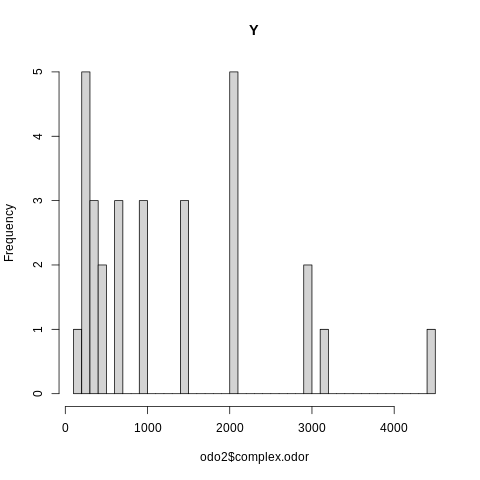

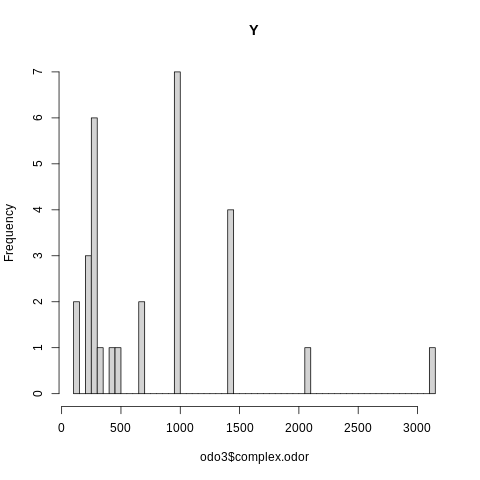

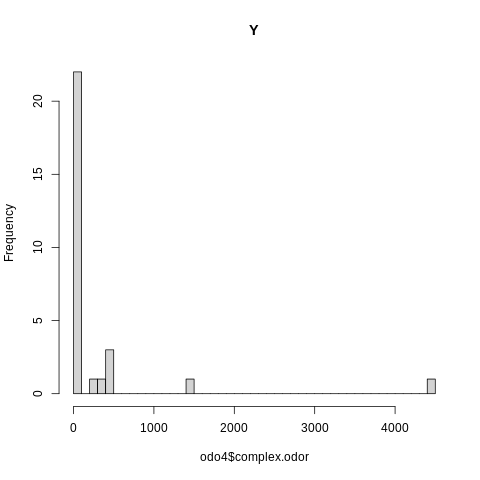

In [10]:
%%R

### 반응 변수
hist(odo1$complex.odor, main = "Y", breaks = 50)
hist(odo2$complex.odor, main = "Y", breaks = 50)
hist(odo3$complex.odor, main = "Y", breaks = 50)
hist(odo4$complex.odor, main = "Y", breaks = 50)

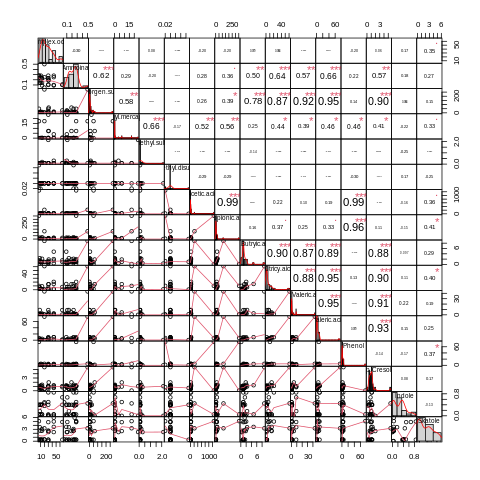

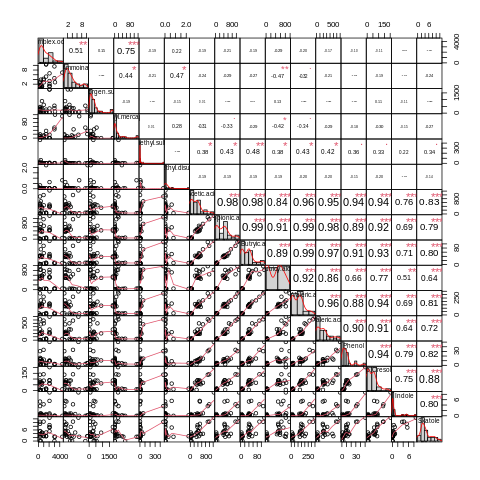

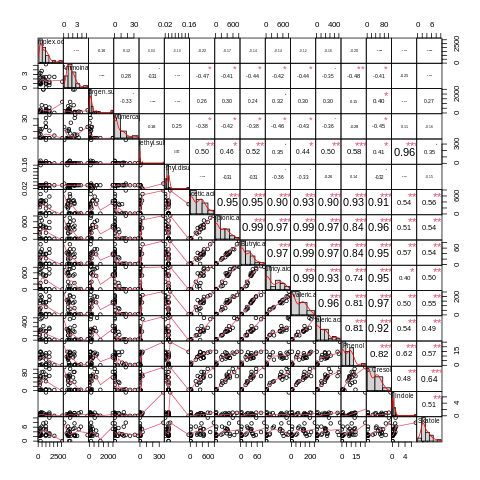

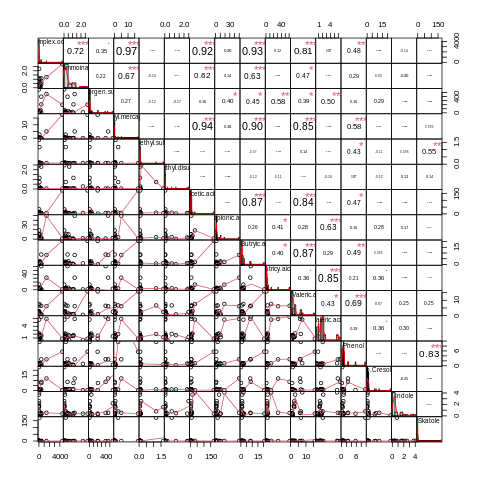

In [11]:
%%R

# as.data.frame(round(cor(odo),4))

chart.Correlation(odo1, histogram = T, pch = 19)
chart.Correlation(odo2, histogram = T, pch = 19)
chart.Correlation(odo3, histogram = T, pch = 19)
chart.Correlation(odo4, histogram = T, pch = 19)

### **4) Log 변환**

- 0이 있으면  0.000001로 변경 후 Log변환 

In [12]:
%%R

logf <- function(odo){
    if (sum(odo==0) > 0) {
        odo[odo == 0] <- 0.000001   
    }
    odo <- log(odo)
    return(odo)
}


In [13]:
%%R

odol1 <- logf(odo1)
odol2 <- logf(odo2)
odol3 <- logf(odo3)
odol4 <- logf(odo4)


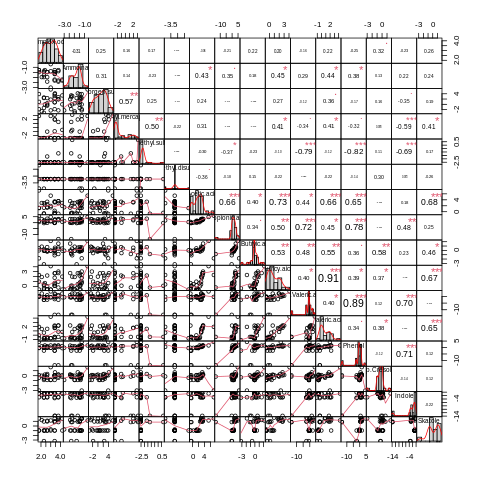

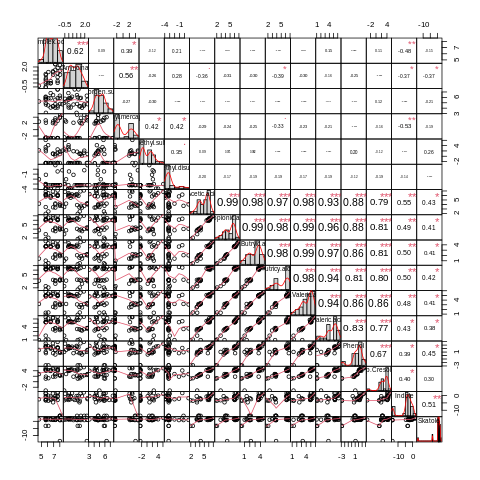

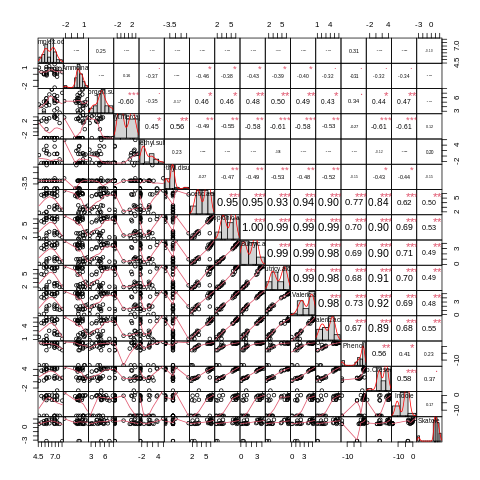

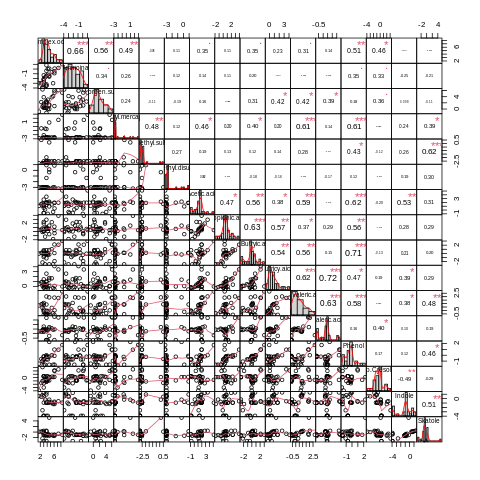

In [14]:
%%R

chart.Correlation(odol1, histogram = T, pch = 19)
chart.Correlation(odol2, histogram = T, pch = 19)
chart.Correlation(odol3, histogram = T, pch = 19)
chart.Correlation(odol4, histogram = T, pch = 19)

### **5) 변수 선택(Boruta)**

- 중요변수 0개로 나오면 모든 변수 사용

In [15]:
%%R

bf <- function(odo) {
    bo <- Boruta(complex.odor ~ ., data = odo, doTrace = 0)
    bs <- getSelectedAttributes(bo, withTentative = TRUE)
    roughFixMod <- TentativeRoughFix(bo)
    bs2 <- getSelectedAttributes(roughFixMod)
    imps <- attStats(roughFixMod)
    imps2 <- imps[imps$decision != "Rejected", c("meanImp","decision")]

    ### 중요변수의 유무 

    if (nrow(imps2) > 1){   # 중요 변수 있음
        odos <- cbind(odo$complex.odor, odo[,rownames(imps2)])
        names(odos)[names(odos) == "odo$complex.odor"] <- "complex.odor"    
        return(odos)    
    } else{                 # 중요 변수 없음
        odos <- odo
        print("의미있는 변수는 없다.")
        return(odos)
    }
    
}


#### **Only 변수선택**

In [16]:
%%R

odos1 <- bf(odo1)
odos2 <- bf(odo2)
odos3 <- bf(odo3)
odos4 <- bf(odo4)

[1] "의미있는 변수는 없다."


#### **Log변환 + 변수선택**

In [17]:
%%R
odosl1 <- bf(odol1)
odosl2 <- bf(odol2)
odosl3 <- bf(odol3)
odosl4 <- bf(odol4)

[1] "의미있는 변수는 없다."


## **2. PLS**
---

### **1) Model 생성**

#### **Only 변수선택**

In [18]:
%%R

# 15개의 잠재 변수 생성 / Validation method : Leave-One-Out

prs1 <- plsr(complex.odor ~ ., data = odos1, ncomp = ncol(odos1)-1, validation = "LOO")
prs2 <- plsr(complex.odor ~ ., data = odos2, ncomp = ncol(odos2)-1, validation = "LOO")
prs3 <- plsr(complex.odor ~ ., data = odos3, ncomp = ncol(odos3)-1, validation = "LOO")
prs4 <- plsr(complex.odor ~ ., data = odos4, ncomp = ncol(odos4)-1, validation = "LOO")

summary(prs1)

Data: 	X dimension: 29 2 
	Y dimension: 29 1
Fit method: kernelpls
Number of components considered: 2

VALIDATION: RMSEP
Cross-validated using 29 leave-one-out segments.
       (Intercept)  1 comps  2 comps
CV           17.22    17.06    17.42
adjCV        17.22    17.06    17.39

TRAINING: % variance explained
              1 comps  2 comps
X              83.466   100.00
complex.odor    5.931    14.08


#### **Log변환 + 변수선택**

In [19]:
%%R

# 15개의 잠재 변수 생성 / Validation method : Leave-One-Out

prsl1 <- plsr(complex.odor ~ ., data = odosl1, ncomp = ncol(odosl1)-1, validation = "LOO")
prsl2 <- plsr(complex.odor ~ ., data = odosl2, ncomp = ncol(odosl2)-1, validation = "LOO")
prsl3 <- plsr(complex.odor ~ ., data = odosl3, ncomp = ncol(odosl3)-1, validation = "LOO")
prsl4 <- plsr(complex.odor ~ ., data = odosl4, ncomp = ncol(odosl4)-1, validation = "LOO")

summary(prsl1)

Data: 	X dimension: 29 15 
	Y dimension: 29 1
Fit method: kernelpls
Number of components considered: 15

VALIDATION: RMSEP
Cross-validated using 29 leave-one-out segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV          0.7314   0.7205   0.7481   0.8061   0.9540    1.307    1.637
adjCV       0.7314   0.7203   0.7474   0.8024   0.9471    1.292    1.613
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       1.643    1.626    1.683     1.865     1.856     1.876     1.785
adjCV    1.618    1.603    1.658     1.837     1.828     1.847     1.759
       14 comps  15 comps
CV        1.782     1.788
adjCV     1.756     1.762

TRAINING: % variance explained
              1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X              58.289    75.69    83.79    87.34    90.05    91.88    94.69
complex.odor    9.731    19.86    29.24    35.13    43.68    53.38    56.11
              8 comps  9 comps  10 comps  11 comps  

### **2) 최적의 ncomp 결정**

#### **Only 변수선택**

In [20]:
%%R
# 최적의 ncomp 수 
ocoms1 = which.min(prs1$validation$PRESS)
ocoms2 = which.min(prs2$validation$PRESS)
ocoms3 = which.min(prs3$validation$PRESS)
ocoms4 = which.min(prs4$validation$PRESS)

cat(ocoms1, ocoms2, ocoms3, ocoms4)

1 2 5 5

#### **Log변환 + 변수선택**

In [21]:
%%R
# 최적의 ncomp 수 
ocomsl1 = which.min(prsl1$validation$PRESS)
ocomsl2 = which.min(prsl2$validation$PRESS)
ocomsl3 = which.min(prsl3$validation$PRESS)
ocomsl4 = which.min(prsl4$validation$PRESS)

cat(ocomsl1, ocomsl2, ocomsl3, ocomsl4)

1 3 2 1

### **3) R-Squared**

#### **Only 변수선택**

##### **(1) validation**

In [22]:
%%R
y1 <- odos1$complex.odor
y2 <- odos2$complex.odor
y3 <- odos3$complex.odor
y4 <- odos4$complex.odor

valid1 <- round(prs1$validation$pred[,,ocoms1], 3) ; fitted1 <- round(prs1$fitted.values[,,ocoms1], 3)
valid2 <- round(prs2$validation$pred[,,ocoms2], 3) ; fitted2 <- round(prs2$fitted.values[,,ocoms2], 3)
valid3 <- round(prs3$validation$pred[,,ocoms3], 3) ; fitted3 <- round(prs3$fitted.values[,,ocoms3], 3)
valid4 <- round(prs4$validation$pred[,,ocoms4], 3) ; fitted4 <- round(prs4$fitted.values[,,ocoms4], 3)

In [23]:
%%R

rs_v1 <- cor(y1, valid1)^2
rs_v2 <- cor(y2, valid2)^2
rs_v3 <- cor(y3, valid3)^2
rs_v4 <- cor(y4, valid4)^2

cat("R2 - Select1 : ", round(rs_v1, 4), "\n")
cat("R2 - Select2 : ", round(rs_v2, 4), "\n")
cat("R2 - Select3 : ", round(rs_v3, 4), "\n")
cat("R2 - Select4 : ", round(rs_v4, 4))

R2 - Select1 :  6e-04 
R2 - Select2 :  0.4928 
R2 - Select3 :  0.0105 
R2 - Select4 :  0.9414

##### **(2) fitted value**

In [24]:
%%R

rs_f1 <- cor(y1, fitted1)^2
rs_f2 <- cor(y2, fitted2)^2
rs_f3 <- cor(y3, fitted3)^2
rs_f4 <- cor(y4, fitted4)^2

cat("R2 - Select1 : ", round(rs_f1, 4), "\n")
cat("R2 - Select2 : ", round(rs_f2, 4), "\n")
cat("R2 - Select3 : ", round(rs_f3, 4), "\n")
cat("R2 - Select4 : ", round(rs_f4, 4))

R2 - Select1 :  0.0593 
R2 - Select2 :  0.6168 
R2 - Select3 :  0.214 
R2 - Select4 :  0.9789

#### **Log변환 + 변수선택**

##### **(1) validation**

In [25]:
%%R
y1 <- odosl1$complex.odor
y2 <- odosl2$complex.odor
y3 <- odosl3$complex.odor
y4 <- odosl4$complex.odor

valid1 <- round(prsl1$validation$pred[,,ocomsl1], 3) ; fitted1 <- round(prsl1$fitted.values[,,ocomsl1], 3)
valid2 <- round(prsl2$validation$pred[,,ocomsl2], 3) ; fitted2 <- round(prsl2$fitted.values[,,ocomsl2], 3)
valid3 <- round(prsl3$validation$pred[,,ocomsl3], 3) ; fitted3 <- round(prsl3$fitted.values[,,ocomsl3], 3)
valid4 <- round(prsl4$validation$pred[,,ocomsl4], 3) ; fitted4 <- round(prsl4$fitted.values[,,ocomsl4], 3)

In [26]:
%%R

rsl_v1 <- cor(y1, valid1)^2
rsl_v2 <- cor(y2, valid2)^2
rsl_v3 <- cor(y3, valid3)^2
rsl_v4 <- cor(y4, valid4)^2

cat("R2 - Log + Select1 : ", round(rsl_v1, 4), "\n")
cat("R2 - Log + Select2 : ", round(rsl_v2, 4), "\n")
cat("R2 - Log + Select3 : ", round(rsl_v3, 4), "\n")
cat("R2 - Log + Select4 : ", round(rsl_v4, 4))

R2 - Log + Select1 :  0.0099 
R2 - Log + Select2 :  0.3051 
R2 - Log + Select3 :  0.0038 
R2 - Log + Select4 :  0.4109

##### **(2) fitted value**

In [27]:
%%R

rsl_f1 <- cor(y1, fitted1)^2
rsl_f2 <- cor(y2, fitted2)^2
rsl_f3 <- cor(y3, fitted3)^2
rsl_f4 <- cor(y4, fitted4)^2

cat("R2 - Log + Select1 : ", round(rsl_f1, 4), "\n")
cat("R2 - Log + Select2 : ", round(rsl_f2, 4), "\n")
cat("R2 - Log + Select3 : ", round(rsl_f3, 4), "\n")
cat("R2 - Log + Select4 : ", round(rsl_f4, 4))

R2 - Log + Select1 :  0.0974 
R2 - Log + Select2 :  0.4615 
R2 - Log + Select3 :  0.1041 
R2 - Log + Select4 :  0.5551

#### **Vaild data R2**

In [28]:
%%R

var2 <- rbind(c(rs_v1, rs_v2, rs_v3, rs_v4), c(rsl_v1, rsl_v2, rsl_v3, rsl_v4))
colnames(var2) <- c("sheet1","sheet2", "sheet3", "sheet4")
rownames(var2) <- c("Only 변수선택", "Log변환+변수선택")
var2

                      sheet1    sheet2      sheet3    sheet4
Only 변수선택    0.000606537 0.4928261 0.010484371 0.9414357
Log변환+변수선택 0.009877199 0.3050688 0.003828289 0.4109240


#### **Fitted data R2**

In [29]:
%%R

fir2 <- rbind(c(rs_f1, rs_f2, rs_f3, rs_f4), c(rsl_f1, rsl_f2, rsl_f3, rsl_f4))
colnames(fir2) <- c("sheet1","sheet2", "sheet3", "sheet4")
rownames(fir2) <- c("Only 변수선택", "Log변환+변수선택")
fir2

                     sheet1    sheet2    sheet3    sheet4
Only 변수선택    0.05930706 0.6167686 0.2140132 0.9788650
Log변환+변수선택 0.09737291 0.4615169 0.1040659 0.5551182


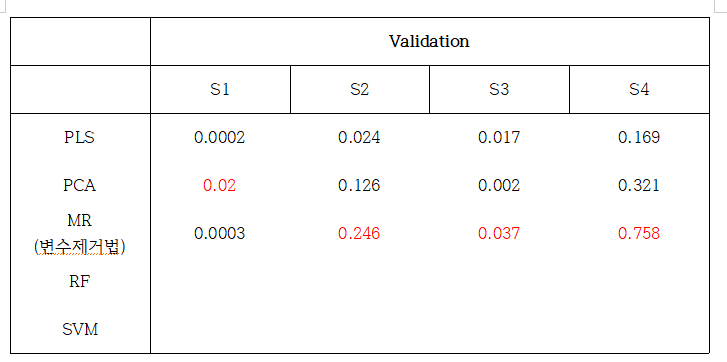